In [4]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
from matplotlib import pyplot as plt # type: ignore
import os

In [5]:
#le o dataset de controle de trafego na Web em LA, pegando apenas 3 colunas especificas do arquivo e converte a colunas de "Date" para formato apropriado
data = pd.read_csv(os.path.join('..\\..\\Dataset\\testes\\casos_diarios_2024_municipio.csv'), delimiter=',',
                   parse_dates=['dt_notificacao']).loc[:, ['dt_notificacao', 'nm_municipio','casos']]

KeyError: "['nm_municipio'] not in index"

Divisão dos dados em treino e validação

In [3]:
#intervalo de dados de treino
train = data.where(
                      (data['dt_notificacao'] < '2024-04-01') 
                    & (data['dt_notificacao'] >= '2024-01-01')
                  ).dropna(subset=["dt_notificacao"])
#intervalo de dados de validação
valid = data.where(data['dt_notificacao'] >= '2024-04-01').dropna(subset=["dt_notificacao"])
#conta quantos dias distintos tem no conjunto de validação 
# h é a quantidade timestamps(pontos especificos na linha do tempo) que se quer prever no futuro
h = valid['dt_notificacao'].nunique()

In [14]:
valid['dt_notificacao'].nunique()

6

In [15]:
#importação da biblioteca utilizada para criar e manipular series temporais
from darts import TimeSeries # type: ignore
#retorna uma lista de todos os dispositivos únicos, para saber quantas series temporais criar
series_names = train['nm_municipio'].unique()
#cria uma serie temporal a partir de um dataframe. 
# Cada série temporal representa a evolução de um valor ao longo do tempo para um grupo específico (neste caso, um tipo de dispositivo)
train_series = TimeSeries.from_group_dataframe(train, time_col='dt_notificacao', value_cols=['casos'], group_cols=['nm_municipio'], fill_missing_dates=False, fillna_value=0.)

In [16]:
from darts.models import KalmanForecaster # type: ignore


In [17]:
# Predictions list to store results
preds = list()

# Iterate over each series in train_series
for i, series in enumerate(train_series):
    try:
        print("epoch:", i)

        # Initialize KalmanForecaster with dim_x=1
        model = KalmanForecaster(dim_x=1)

        # Fit the model on the current time series
        model.fit(series=series)

        # Predict future values (h steps ahead)
        p = model.predict(h).pd_dataframe()

        # Keep original date index
        p = p.set_index(series.time_index[-h:])  # Align predictions with the last h dates of series

        # Add the 'nm_municipio' column
        p['nm_municipio'] = series_names[i]

        # print(p)
        # print(series.time_index)
        # print(series)

        # break

        # Append predictions to list
        preds.append(p)

    except Exception as exp:
        print(f"Error at epoch {i}: {exp}")

        # 2019-10-06     -9.123956   Adamantina
        # 2019-10-06     -64.456469   Adamantina


# Concatenate predictions and rename 'casos' to 'Predicted'
preds = pd.concat(preds, axis=0, ignore_index=False).rename(columns={'casos': 'Predicted'})

epoch: 0
Error at epoch 0: negative dimensions are not allowed
epoch: 1
Error at epoch 1: negative dimensions are not allowed
epoch: 2
Error at epoch 2: negative dimensions are not allowed
epoch: 3
Error at epoch 3: negative dimensions are not allowed
epoch: 4
Error at epoch 4: negative dimensions are not allowed
epoch: 5
Error at epoch 5: negative dimensions are not allowed
epoch: 6
Error at epoch 6: negative dimensions are not allowed
epoch: 7
Error at epoch 7: negative dimensions are not allowed
epoch: 8
Error at epoch 8: negative dimensions are not allowed
epoch: 9
Error at epoch 9: negative dimensions are not allowed
epoch: 10
Error at epoch 10: negative dimensions are not allowed
epoch: 11
Error at epoch 11: negative dimensions are not allowed
epoch: 12
Error at epoch 12: negative dimensions are not allowed
epoch: 13
Error at epoch 13: negative dimensions are not allowed
epoch: 14
Error at epoch 14: negative dimensions are not allowed
epoch: 15
Error at epoch 15: negative dimensi

ValueError: No objects to concatenate

In [9]:
#junta os dados r5eais com os dados previstos
preds = preds.merge(train, on=['dt_notificacao', 'nm_municipio'], how='left')

In [10]:
#usa o MAPE para medir o quao distantes estao os valores dos reais
from sklearn.metrics import mean_absolute_percentage_error # type: ignore
mean_absolute_percentage_error(preds['casos'], preds['Predicted'])

8.072427359088605e+17

In [11]:
preds

,dt_notificacao,Predicted,nm_municipio,casos
0,2023-10-01,15.328029,Adamantina,10.0
1,2023-11-01,13.156236,Adamantina,9.0
2,2023-12-01,11.292159,Adamantina,5.0
3,2024-01-01,9.692198,Adamantina,8.0
4,2024-02-01,8.318933,Adamantina,35.0
...,...,...,...,...
3865,2023-11-01,5.090222,Zacarias,1.0
3866,2023-12-01,2.780224,Zacarias,0.0
3867,2024-01-01,1.518528,Zacarias,0.0
3868,2024-02-01,0.829404,Zacarias,0.0


In [12]:
train['dt_notificacao'].unique()

<DatetimeArray>
['2014-01-01 00:00:00', '2014-02-01 00:00:00', '2014-03-01 00:00:00',
 '2014-04-01 00:00:00', '2014-05-01 00:00:00', '2014-06-01 00:00:00',
 '2014-07-01 00:00:00', '2014-08-01 00:00:00', '2014-09-01 00:00:00',
 '2014-10-01 00:00:00',
 ...
 '2023-07-01 00:00:00', '2023-08-01 00:00:00', '2023-09-01 00:00:00',
 '2023-10-01 00:00:00', '2023-11-01 00:00:00', '2023-12-01 00:00:00',
 '2024-01-01 00:00:00', '2024-02-01 00:00:00', '2024-03-01 00:00:00',
                 'NaT']
Length: 124, dtype: datetime64[ns]

In [15]:
import matplotlib.dates as mdates

TypeError: list indices must be integers or slices, not str

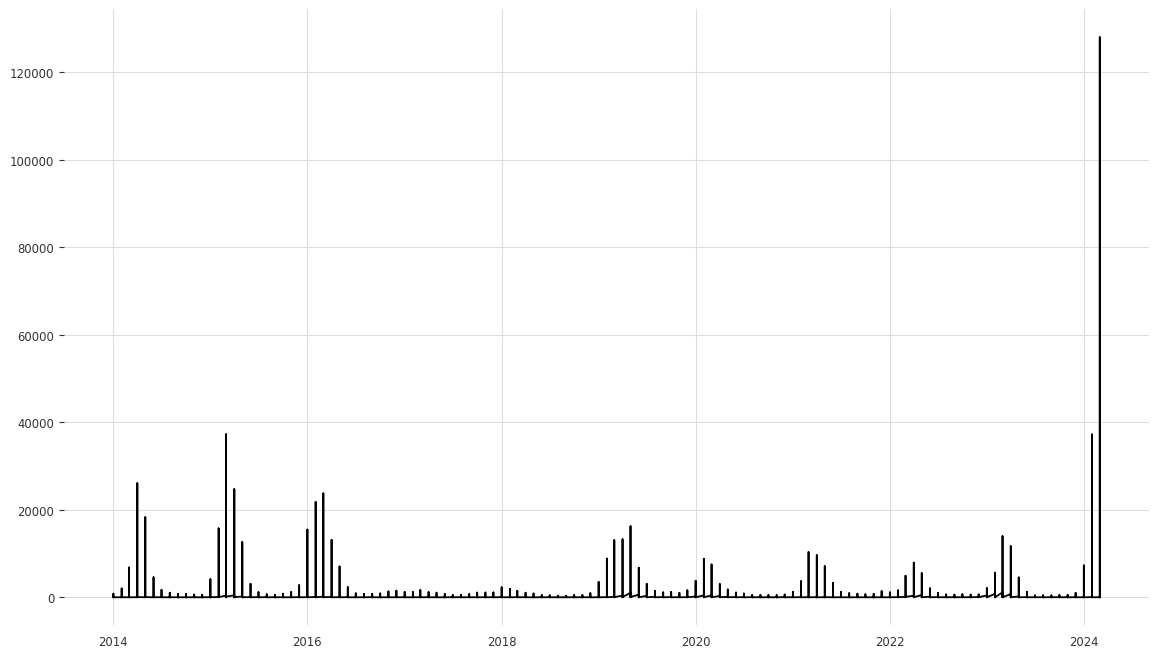

In [20]:
 # Plotar os resultados
plt.figure(figsize=(14, 8), dpi=100)
plt.plot(train['dt_notificacao'], train['casos'], label='Treino')
plt.plot(preds['dt_notificacao'], preds['casos'], label='Teste', color='orange')
plt.plot(preds['dt_notificacao'].astype('date'), preds['Predicted'].astype(int), label='Previsão Filtro de Kalman', color='green')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))
plt.title('Previsão com Filtro de Kalman')
plt.xlabel('Data')
plt.ylabel('Casos')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from darts.models import KalmanForecaster

preds = list()
for i, series in enumerate(train_series):
    model = KalmanForecaster(dim_x=100)
    model.fit(series=series)
    p = model.predict(h, num_samples=100)
    p = [p.quantile_df(q) for q in [0.05, 0.5, 0.95]]
    p = pd.concat(p, axis=1).reset_index()
    p['Device Category'] = series_names[i]
    preds.append(p)
preds = pd.concat(preds, axis=0, ignore_index=True)
preds = preds.merge(valid, on=['Date', 'Device Category'], how='left')

KeyboardInterrupt: 

C:\Users\asawoi\AppData\Local\Temp\ipykernel_28396\4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
C:\Users\asawoi\AppData\Local\Temp\ipykernel_28396\4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
C:\Users\asawoi\AppData\Local\Temp\ipykernel_28396\4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

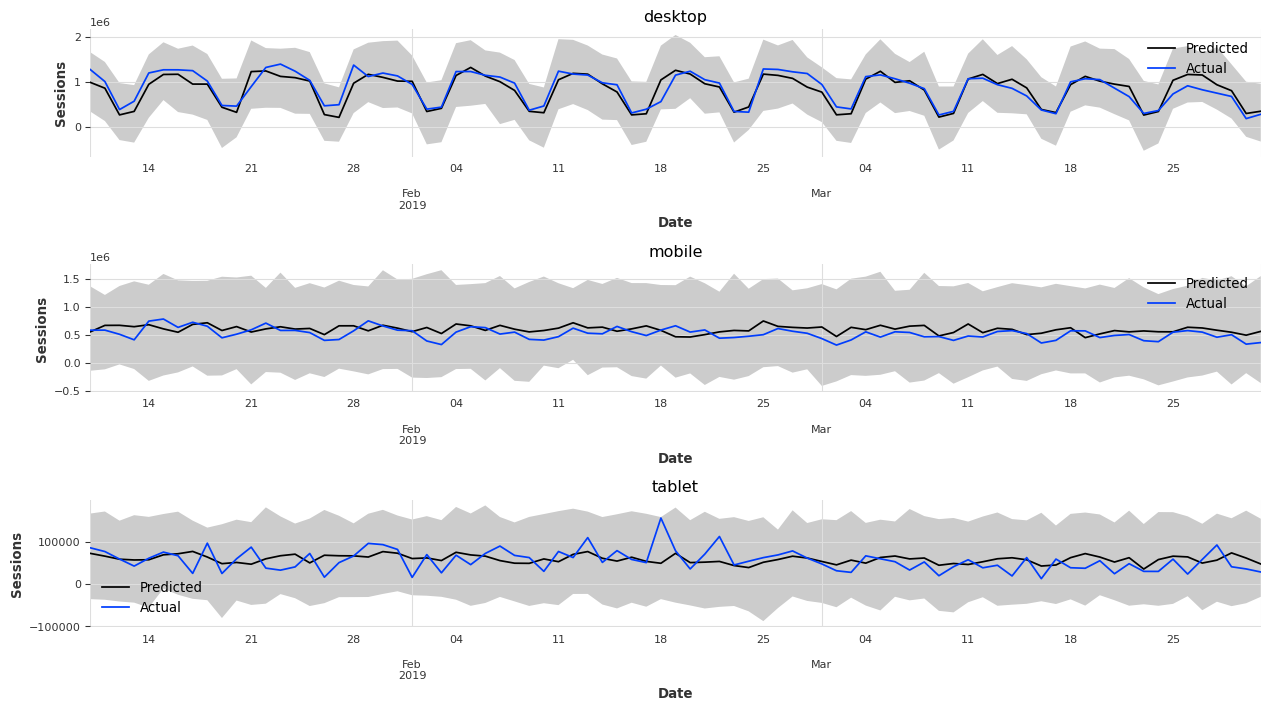

In [51]:
fig,ax = plt.subplots(3,1,figsize=(1280/96, 720/96), dpi=96)
preds_ = preds[preds['Date'] >= '2019-01-10']
for ax_, device in enumerate(preds_['Device Category'].unique()):
    p_ = preds_.loc[preds_['Device Category'] == device]
    p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
    ax[ax_].fill_between(p_['Date'], p_['Sessions_0.05'], p_['Sessions_0.95'], alpha=0.2)
    p_.plot(x='Date', y=['Predicted', 'Actual'], ax=ax[ax_], title=device)
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sessions')
fig.tight_layout()

In [52]:
from sklearn.metrics import mean_pinball_loss
for q in [0.05, 0.5, 0.95]:
    print(f'Pinball loss at {q}: {mean_pinball_loss(preds["Sessions"], preds[f"Sessions_{q}"])}')

Pinball loss at 0.05: 268637.8143807489
Pinball loss at 0.5: 51956.13305713162
Pinball loss at 0.95: 271511.7489896879
